In [1]:
import subprocess
import pandas as pd
import numpy as np
import itertools
from itertools import chain
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("cork.txt")
cork_map = LinearSegmentedColormap.from_list("cork", cm_data)

In [2]:
nbelts = 36

## Latitudinal temperature profiles

['0'] 0. 2.5 ['1.0'] ['0.7'] ['1'] F0 1.5 0.001
288.076
['0'] 0. 1.25 ['1.0'] ['0.7'] ['1'] Sun 1.0 0.001
291.866
['0'] 0. 0.53 ['1.0'] ['0.7'] ['1'] K5 0.6 0.001
290.026
['0'] 23.5 2.5 ['1.0'] ['0.7'] ['1'] F0 1.5 0.001
287.836
['0'] 23.5 1.25 ['1.0'] ['0.7'] ['1'] Sun 1.0 0.001
292.108
['0'] 23.5 0.53 ['1.0'] ['0.7'] ['1'] K5 0.6 0.001


No handles with labels found to put in legend.
No handles with labels found to put in legend.


290.203


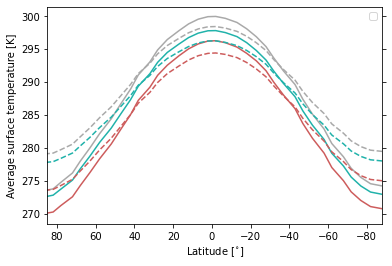

In [7]:
# What is the temperature gradient across the planet?
start = ["Warm"] 
STAR = ["F0","Sun","K5"] 
smass = ["1.5","1.0","0.6"]

#a0 = ["2.7","1.4","0.6"]     # For Figure 5 in the paper

# Figure 4
#a0 = ["2.2","1.1","0.45"]     # Low
#a0 = ["2.4","1.25","0.53"]     # Intermediate (Figure 4)
a0 = ["2.5","1.25","0.53"]
#a0 = ["2.75","1.42","0.6"]    # High

obl = ["0.","23.5"]
ocean = ["0.7"]
igeog = ["1"]
pco2i = ["1.0"]

if start==["Cold"]:
    icoldflag = ["1"]
else:
    icoldflag = ["0"]
    
a_max = max(float(sub) for sub in a0) 
a_min = min(float(sub) for sub in a0)    

sem_ax = len(a0)  
pco2 = len(pco2i)

pco2_plot = [3,2.5,2,1.5,1,0.5,0.1,0.01]
pco2_plot = np.array([pco2_plot,]*sem_ax*2).transpose()

with open("input_ebm.dat", "r") as f:
    main = f.read()
    
splitfile = main.split('\n')

temp_ave = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
latitude_plot = np.zeros((nbelts,len(a0)*2),dtype=np.float32)

s=0 
n=0

var = ["icoldflag","obl","a0","pco2i","ocean","igeog","STAR","smass","val"]

for b in range(len(obl)):
    for c in range(len(STAR)):
            if b==0:
                #val=["1.","0.25","0.2"] # July paper figure
                val=["0.001","0.001","0.001"]
            else:
                # val=["1.","0.25","0.2"] # July paper figure
                val=["0.001","0.001","0.001"]
            print (icoldflag,obl[b],a0[c],pco2i,ocean,igeog,STAR[c],smass[c],val[c])
            
            with open("input_ebm.dat", "r") as f:
                main = f.read()
                for j, line in enumerate(splitfile):
                    if var[0] in line:
                        splitfile[j] = 'icoldflag:       %s' % icoldflag[0]
                    if var[1] in line:
                        splitfile[j] = 'obl:             %s' % obl[b]
                    if var[2] in line:
                        splitfile[j] = 'a0:              %s' % a0[c]            
                    if var[3] in line:
                        splitfile[j] = 'pco2i:           %s' % pco2i[0] 
                    if var[4] in line:
                        splitfile[j] = 'ocean:           %s' % ocean[0]            
                    if var[5] in line:
                        splitfile[j] = 'igeog:           %s' % igeog[0]   
                    if var[6] in line:
                        splitfile[j] = 'STAR:      %s' % STAR[c]
                    if var[7] in line:
                        splitfile[j] = 'smass:           %s' % smass[c]    
                    if var[8] in line:
                        splitfile[j] = 'val:     %s' % val[c] 
        
                with open("input_ebm.dat", "w") as f:
                    f.write('\n'.join(splitfile))              

        
                if j==0:
                    subprocess.call(['make clean'], shell=True)
                    subprocess.call(['make'], shell=True)
            
                subprocess.call(['./driver'],shell=True)
            
    
                df = pd.read_csv('out/model.out', header=None)
                df = pd.DataFrame(df[0].str.split(' ').tolist())
        
                #Average temperature from text file
                temp_av = df.iloc[56:72,14]
                temp_av = temp_av.append(df.iloc[72:74,15])
                temp_av = temp_av.append(df.iloc[74:76,16])
                temp_av = temp_av.append(df.iloc[76:92,15])
                temp_av = np.array(temp_av, dtype = np.float32)
                
                temp_av_value = df.iloc[42,7]
                print (temp_av_value)
                
                latitude = df.iloc[56:72,4]
                latitude = latitude.append(df.iloc[72:74,5])
                latitude = latitude.append(df.iloc[74:76,6])
                latitude = latitude.append(df.iloc[76:92,5])
                latitude = np.array(latitude, dtype = np.float32)
                
                temp_ave[:,n] = temp_av
                latitude_plot[:,n]=latitude

                n+=1

colori=["indianred","darkgrey","lightseagreen","indianred","darkgrey","lightseagreen"]
style = ["-","-","-","--","--","--"]
labello=["F0 star", "Sun", "K5 star"]

plt.figure(6)
for i in range(temp_ave.shape[1]):
    
    latitude = latitude_plot[:,i]
    latitude_pole1 = latitude[:-32]
    latitude_pole2 = latitude[32:]
    latitude_eq = latitude_plot[3:-3]

    temp_ave_plot = temp_ave[:,i]
    temp_ave_pole1 = temp_ave_plot[:-32]
    temp_ave_pole2 = temp_ave_plot[32:]
    temp_ave_eq = temp_ave_plot[3:-3]
    
    if i!=7:
        plt.plot(latitude,temp_ave_plot,color=colori[i],linestyle=style[i])
    else:   
        plt.plot(latitude_pole1,temp_ave_pole1,color=colori[i],linestyle=':')
        plt.plot(latitude_pole2,temp_ave_pole2,color=colori[i],linestyle=':')
        plt.plot(latitude_eq,temp_ave_eq,color=colori[i],linestyle=style[i])

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)

simArtist = plt.Line2D((0,1),(0,0), color='k')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')

plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['$0^{\circ}$','$23.5^{\circ}$'],bbox_to_anchor=(0.81, 0.7),borderaxespad=0.,fontsize=8)
plt.legend(bbox_to_anchor=(1.25, 1.01))
plt.legend()
plt.xlabel("Latitude [$^{\circ}$]")
plt.ylabel("Average surface temperature [K]")
ax.yaxis.set_ticks_position('both')
plt.xlim([85, -88])
plt.savefig('Figures/T_ave_icold{}_a{}.pdf'.format(icoldflag[0],a0[0]), bbox_inches='tight',format='pdf')
plt.show()

## Amount of condensed CO2 ice

In [5]:
# How much CO_{2} for a given initial atmospheric pressure?
icoldflag = ["1"]
start = ["Cold"] # "Cold" or "Warm"
STAR = ["F0","Sun","K5"] # "Sun" or "K5"
smass = ["1.5","1.","0.6"]
#a0 = ["2.7","1.4","0.6"] # was 2.7 to reproduce first paper draft
a0 = ["2.5","1.25","0.53"]
obl = ["0","23.5"]

ocean = ["0.7"]
igeog = ["1"]
pco2i = ["3.0","2.5","2.0","1.5","1.0","0.5","0.1","0.01"]
#pco2i = ["3.0","2.75","2.5","2.25","2.0","1.75","1.5","1.25","1.0","0.75","0.5","0.25","0.1","0.05","0.01"]

if start==["Cold"]:
    icoldflag = ["1"]
else:
    icoldflag = ["0"]
    
a_max = max(float(sub) for sub in a0) 
a_min = min(float(sub) for sub in a0)    

sem_ax = len(a0)  
pco2 = len(pco2i)

pco2_plot = [3,2.5,2,1.5,1,0.5,0.1,0.01]
pco2_plot = np.array([pco2_plot,]*sem_ax*2).transpose()

with open("input_ebm.dat", "r") as f:
    main = f.read()
    
splitfile = main.split('\n')

gl = np.zeros((len(pco2i),len(a0)*2),dtype=np.float32)
CO2_ice = np.zeros((len(pco2i),len(a0)*2),dtype=np.float32)
temp_ave = np.zeros((nbelts,len(a0)*2),dtype=np.float32)
latitude_plot = np.zeros((nbelts,len(a0)*2),dtype=np.float32)

s=0 
n=0

var = ["icoldflag","obl","a0","pco2i","ocean","igeog","STAR","smass","val"]

for b in range(len(obl)):
    
    
    if b==0:
        #val=["0.35","0.35","0.35"]
        val=["0.001","0.001","0.001"]
    else:
        #val=["0.35","0.35","0.35"]
        val=["0.001","0.001","0.001"]
    
    for c in range(len(STAR)):
        for d in range(len(pco2i)):
            print (icoldflag,obl[b],a0[c],pco2i[d],ocean,igeog,STAR[c],smass[c],val[c])
                
            with open("input_ebm.dat", "r") as f:
                main = f.read()
                for j, line in enumerate(splitfile):
                    if var[0] in line:
                        splitfile[j] = 'icoldflag:       %s' % icoldflag[0]
                    if var[1] in line:
                        splitfile[j] = 'obl:             %s' % obl[b]
                    if var[2] in line:
                        splitfile[j] = 'a0:              %s' % a0[c]            
                    if var[3] in line:
                        splitfile[j] = 'pco2i:           %s' % pco2i[d] 
                    if var[4] in line:
                        splitfile[j] = 'ocean:           %s' % ocean[0]            
                    if var[5] in line:
                        splitfile[j] = 'igeog:           %s' % igeog[0]   
                    if var[6] in line:
                        splitfile[j] = 'STAR:      %s' % STAR[c]
                    if var[7] in line:
                        splitfile[j] = 'smass:           %s' % smass[c] 
                    if var[8] in line:
                        splitfile[j] = 'val:     %s' % val[c] 
                        
                with open("input_ebm.dat", "w") as f:
                    f.write('\n'.join(splitfile))              

        
                if j==0:
                    subprocess.call(['make clean'], shell=True)
                    subprocess.call(['make'], shell=True)
            
                subprocess.call(['./driver'],shell=True)
            
    
                df = pd.read_csv('out/model.out', header=None)
                df = pd.DataFrame(df[0].str.split(' ').tolist())
        
                # CO2 surface ice
                for m in range(len(df)):
                    if df.iloc[m,2] == "atmospheric" and df.iloc[m,10]!=None:
                        CO2_ice[n,s] = df.iloc[m,10]
                        break
                    elif df.iloc[m,2] == "atmospheric" and df.iloc[m,10]==None:
                        CO2_ice[n,s] = df.iloc[m,9]
                    if CO2_ice[n,s]<0:
                        exit
                        break
                print (CO2_ice[n,s])                
        
                #Average temperature from text file
                temp_av = df.iloc[56:72,14]
                temp_av = temp_av.append(df.iloc[72:74,15])
                temp_av = temp_av.append(df.iloc[74:76,16])
                temp_av = temp_av.append(df.iloc[76:92,15])
                temp_av = np.array(temp_av, dtype = np.float32)
                
                latitude = df.iloc[56:72,4]
                latitude = latitude.append(df.iloc[72:74,5])
                latitude = latitude.append(df.iloc[74:76,6])
                latitude = latitude.append(df.iloc[76:92,5])
                latitude = np.array(latitude, dtype = np.float32)
                
                temp_ave[:,s] = temp_av
                latitude_plot[:,s]=latitude
                
            if n==7:
                n=n-7
                s+=1
            else:
                n+=1

['1'] 0 2.5 3.0 ['0.7'] ['1'] F0 1.5 0.001
0.012
['1'] 0 2.5 2.5 ['0.7'] ['1'] F0 1.5 0.001
0.017
['1'] 0 2.5 2.0 ['0.7'] ['1'] F0 1.5 0.001
0.034
['1'] 0 2.5 1.5 ['0.7'] ['1'] F0 1.5 0.001
0.081
['1'] 0 2.5 1.0 ['0.7'] ['1'] F0 1.5 0.001
0.079
['1'] 0 2.5 0.5 ['0.7'] ['1'] F0 1.5 0.001
7.891
['1'] 0 2.5 0.1 ['0.7'] ['1'] F0 1.5 0.001
9.64
['1'] 0 2.5 0.01 ['0.7'] ['1'] F0 1.5 0.001
3.718
['1'] 0 1.25 3.0 ['0.7'] ['1'] Sun 1. 0.001
0.007
['1'] 0 1.25 2.5 ['0.7'] ['1'] Sun 1. 0.001
0.03
['1'] 0 1.25 2.0 ['0.7'] ['1'] Sun 1. 0.001
0.044
['1'] 0 1.25 1.5 ['0.7'] ['1'] Sun 1. 0.001
0.098
['1'] 0 1.25 1.0 ['0.7'] ['1'] Sun 1. 0.001
7.803
['1'] 0 1.25 0.5 ['0.7'] ['1'] Sun 1. 0.001
3.905
['1'] 0 1.25 0.1 ['0.7'] ['1'] Sun 1. 0.001
1.837
['1'] 0 1.25 0.01 ['0.7'] ['1'] Sun 1. 0.001
3.345
['1'] 0 0.53 3.0 ['0.7'] ['1'] K5 0.6 0.001
0.011
['1'] 0 0.53 2.5 ['0.7'] ['1'] K5 0.6 0.001
0.013
['1'] 0 0.53 2.0 ['0.7'] ['1'] K5 0.6 0.001
0.769
['1'] 0 0.53 1.5 ['0.7'] ['1'] K5 0.6 0.001
0.808
['1'] 0 

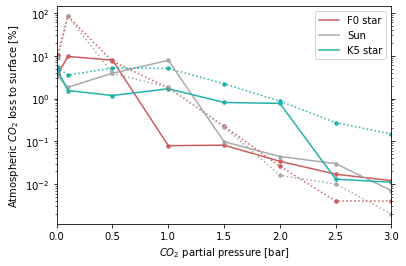

In [6]:
# pco2_plot = [3,2.75,2.5,2.25,2,1.75,1.5,1.25,1,0.75,0.5,0.25,0.1,0.05,0.01]
# pco2_plot = np.array([pco2_plot,]*sem_ax*2).transpose()

colori=["indianred","darkgrey","lightseagreen","indianred","darkgrey","lightseagreen"]
style = ["-","-","-",":",":",":"]
labello=["F0 star", "Sun", "K5 star"]

plt.figure(5)
for i in range(pco2_plot.shape[1]):
    if i==0 or i==1 or i==2:
        plt.plot(pco2_plot[:,i],CO2_ice[:,i],color=colori[i],linestyle=style[i],label=labello[i])
    else:
        plt.plot(pco2_plot[:,i],CO2_ice[:,i],color=colori[i],linestyle=style[i])
    plt.scatter(pco2_plot[:,i],CO2_ice[:,i],color=colori[i],s=12)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)

simArtist = plt.Line2D((0,1),(0,0), color='k')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')

plt.legend()
plt.semilogy()
plt.xlabel("$CO_{\mathrm{2}}$ partial pressure [bar]")
plt.ylabel("Atmospheric $CO_{\mathrm{2}}$ loss to surface [%]")
ax.yaxis.set_ticks_position('both')
plt.xlim([0,3])
plt.savefig('CO2_ice.pdf', bbox_inches='tight',format='pdf')
plt.show()

In [ ]:
# We only have to change these 3 parameters
start = ["Warm"] # "Cold" or "Warm"
STAR = ["F0"]   # "Sun" or "K5" or "F0"
obl = ["23.5"]
val = ["0.001"] # Sun --> 0.05 K5 --> 0.04 or 0.05 F0 --> 0.035,0.065 (cold start), 0.05 (warm start) 

# Other parameters
ocean = ["0.7"]
igeog = ["1"]
pco2i = ["3.0","2.75","2.5","2.25","2.0","1.75","1.5","1.25","1.0","0.75","0.5","0.25","0.1","0.05","0.01"]

if start==["Cold"]:
    icoldflag = ["1"]
else:
    icoldflag = ["0"]

if STAR == ["Sun"]:
    smass = ["1.0"]
    a0 = ["1.00","1.025","1.05","1.075","1.10","1.125","1.15","1.175","1.20","1.225","1.25","1.275","1.30","1.325","1.35","1.375","1.40","1.425","1.45","1.475","1.5"]
#    a0 = ["1.15","1.175","1.20","1.225","1.25"]
elif STAR == ["K5"]:
    smass = ["0.6"]
    #a0 = ["0.4","0.42","0.44","0.46","0.48","0.5","0.52","0.54","0.56","0.58","0.6"]
    a0 = ["0.4","0.41","0.42","0.43","0.44","0.45","0.46","0.47","0.48","0.49","0.5","0.51","0.52","0.53","0.54","0.55","0.56","0.57","0.58","0.59","0.6"]
    #a0 = ["0.58","0.6"]
else:
    smass = ["1.5"]
    a0 = ["2.00","2.05","2.10","2.15","2.20","2.25","2.30","2.35","2.40","2.45","2.50","2.55","2.60","2.65","2.70","2.75","2.80","2.85","2.90","2.95","3.00"]
    #a0 = ["2.70","2.80"]
    
a_max = max(float(sub) for sub in a0) 
a_min = min(float(sub) for sub in a0)
pco2_max = max(float(sub) for sub in pco2i) 
pco2_min = min(float(sub) for sub in pco2i)     

sem_ax = len(a0)  
pco2 = len(pco2i)

sem_ax_plot = np.linspace(a_min,a_max,sem_ax)
sem_ax_plot = np.reshape(sem_ax_plot, (sem_ax))
sem_ax_plot = np.array([sem_ax_plot,]*pco2)

pco2_plot = [3,2.75,2.5,2.25,2,1.75,1.5,1.25,1,0.75,0.5,0.25,0.1,0.05,0.01]
pco2_plot = np.array([pco2_plot,]*sem_ax).transpose()

with open("input_ebm.dat", "r") as f:
    main = f.read()
    
splitfile = main.split('\n')

gl = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
points = np.zeros((len(pco2i)+len(a0),2),dtype=np.float32)
text = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
CO2_ice = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
Delta_T = np.zeros((len(pco2i),len(a0)),dtype=np.float32)
T_min = np.zeros((len(pco2i),len(a0)),dtype=np.float32)

s=0 
n=0

var = ["icoldflag","obl","a0","pco2i","ocean","igeog","STAR","smass","val"]

for i in itertools.product(icoldflag,obl,a0,pco2i,ocean,igeog,STAR,smass,val):
    
    a,b,c,d,e,f,g,h,k = i            
    print (i)
    
    with open("input_ebm.dat", "r") as f:
        main = f.read()
        for j, line in enumerate(splitfile):
            if var[0] in line:
                splitfile[j] = 'icoldflag:       %s' % i[0]
            if var[1] in line:
                splitfile[j] = 'obl:             %s' % i[1]
            if var[2] in line:
                splitfile[j] = 'a0:              %s' % i[2]            
            if var[3] in line:
                #splitfile[j] = 'pco2i:           %s' % i[3] 
                if STAR==["K5"] and start==["Cold"] and n==7 and s==16: # 0.56 AU,1.25 bar
                    splitfile[j] = 'pco2i:           %s' % 1.5
                    
                elif STAR==["F0"] and start==["Cold"] and n==13 and s==7: # 2.35 AU,0.05 bar
                    splitfile[j] = 'pco2i:           %s' % 0.1
                else:
                    splitfile[j] = 'pco2i:           %s' % i[3] 
            if var[4] in line:
                splitfile[j] = 'ocean:           %s' % i[4]            
            if var[5] in line:
                splitfile[j] = 'igeog:           %s' % i[5]   
            if var[6] in line:
                splitfile[j] = 'STAR:      %s' % i[6]
            if var[7] in line:
                splitfile[j] = 'smass:           %s' % i[7] 
            if var[8] in line:
                splitfile[j] = 'val:     %s' % i[8] 
        
        with open("input_ebm.dat", "w") as f:
            f.write('\n'.join(splitfile))
        
        if j==0:
            subprocess.call(['make clean'], shell=True)
            subprocess.call(['make'], shell=True)
            
        subprocess.call(['./driver'],shell=True)
    
        df = pd.read_csv('out/model.out', header=None)
        df = pd.DataFrame(df[0].str.split(' ').tolist())
        
        # CO2 surface ice
        for m in range(len(df)):
            if df.iloc[m,2] == "atmospheric" and df.iloc[m,10]!=None:
                CO2_ice[n,s] = df.iloc[m,10]
                break
            elif df.iloc[m,2] == "atmospheric" and df.iloc[m,10]==None:
                CO2_ice[n,s] = df.iloc[m,9]
            if CO2_ice[n,s]<0:
                exit
                break
        print (CO2_ice[n,s])
        
        #Average temperature from text file
        temp_av = df.iloc[56:72,14]
        temp_av = temp_av.append(df.iloc[72:74,15])
        temp_av = temp_av.append(df.iloc[74:76,16])
        temp_av = temp_av.append(df.iloc[76:92,15])
        temp_av = np.array(temp_av, dtype = np.float32)
        
        #Minimum temperature from text file
        temp_min = df.iloc[56:72,20]
        temp_min = temp_min.append(df.iloc[72:74,21])
        temp_min = temp_min.append(df.iloc[74:76,22])
        temp_min = temp_min.append(df.iloc[76:92,21])
        temp_min = np.array(temp_min, dtype = np.float32)
                
        # 1: Snowball planet, 4: Ice-free planets, 2: Partially ice-free with CO2  3: Partially ice free with no CO2
        if all(i < 263 for i in temp_av) and CO2_ice[n,s]>0:
            gl[n, s] = 1 # blue
        elif all(k > 263 for k in temp_av):
            gl[n,s] = 4 # red
        else:
            if CO2_ice[n,s]>0:
                gl[n,s] = 2 # light blue
            elif CO2_ice[n,s]==0:
                gl[n,s] = 3 # light red
            else:
                gl[n,s] = 1 # blue
            
        Delta_T[n,s] = np.max(temp_av)-np.min(temp_av)
        T_min[n,s] = np.min(temp_min)
        
#     if n==7:
#         n=n-7
#         s+=1
#     else:
#         n+=1
    if n==14:
        n=n-14
        s+=1
    else:
        n+=1

('0', '23.5', '2.00', '3.0', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '2.75', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '2.5', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '2.25', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '2.0', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '1.75', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '1.5', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '1.25', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '1.0', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '0.75', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '0.5', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '0.25', '0.7', '1', 'F0', '1.5', '0.001')
0.0
('0', '23.5', '2.00', '0.1', '0.7', '1', 'F0', '1.5', '0.001')
0.007
('0', '23.5', '2.00', '0.05', '0.7', '1', 'F0', '1.5', '0.001')
0.007
('0', '23.5', '2.00', '0.01', '0.7', '1', 'F0', '1.

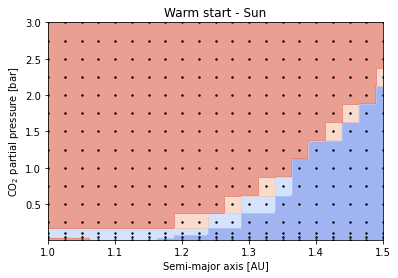

In [16]:
STAR = ["Sun"]
start = ["Warm"]




s=0 
n=0

# for i in itertools.product(icoldflag,obl,a0,pco2i,ocean,igeog,STAR,smass,val):
    
#     a,b,c,d,e,f,g,h,k = i            

#     if CO2_ice[n,s]<0:
   
#         gl[n,s] = 2 # light blue
            
#         Delta_T[n,s] = np.max(temp_av)-np.min(temp_av)
#         T_min[n,s] = np.min(temp_min)

#     if n==14:
#         n=n-14
#         s+=1
#     else:
#         n+=1



sa_plot = np.reshape(sem_ax_plot, (len(sem_ax_plot[0])*len(sem_ax_plot),1))
pc_plot = np.reshape(pco2_plot, (len(pco2_plot[0])*len(pco2_plot),1))
gl0 = np.reshape(gl, (len(gl[0])*len(gl),1))
# gl_K5warm = np.reshape(gl, (len(gl[0])*len(gl),1))
# gl_K5cold = np.reshape(gl, (len(gl[0])*len(gl),1))
# gl_Suncold = np.reshape(gl, (len(gl[0])*len(gl),1))
# gl_Sunwarm = np.reshape(gl, (len(gl[0])*len(gl),1))
points = np.column_stack((sa_plot,pc_plot))

xi,yi = np.mgrid[a_min:a_max:200j, pco2_min:pco2_max:200j]

if STAR==["K5"]:        
    STAR = ["K5 star"]
    if start == ["Warm"]:
        gl_K5warm = gl0
        zi = griddata(points, gl_K5warm, (xi, yi), method="nearest").reshape(200, 200)
    else:
        gl_K5cold = gl0
        zi = griddata(points, gl_K5cold, (xi, yi), method="nearest").reshape(200, 200)

if STAR==["Sun"]:        
    if start == ["Warm"]:
        gl_Sunwarm = gl0
        zi = griddata(points, gl_Sunwarm, (xi, yi), method="nearest").reshape(200, 200)
    else:
        gl_Suncold = gl0
        zi = griddata(points, gl_Suncold, (xi, yi), method="nearest").reshape(200, 200)        
        
if STAR==["F0"]:        
    STAR = ["F0 star"]
    if start == ["Warm"]:
        #gl_F0warm = gl0
        zi = griddata(points, gl_F0warm, (xi, yi), method="nearest").reshape(200, 200)
    else:
        #gl_F0cold = gl0
        zi = griddata(points, gl_F0cold, (xi, yi), method="nearest").reshape(200, 200) 
    
zi = np.around(zi)

size =2
fig, ax = plt.subplots()
#colors = ["blue","grey","red","green"]

plt.figure(1)
plt.contourf(xi,yi,zi,levels=[0,1,2,3,4],cmap="coolwarm", alpha=0.6)
plt.scatter(sem_ax_plot,pco2_plot,color='black', s=size)
# for i in range(len(gl)):
#     for j in range(int(gl.size/len(gl))):
#         plt.scatter(sem_ax_plot[i,j],pco2_plot[i,j],color=colors[int(gl[i,j])-1],s=size)
plt.xlabel('Semi-major axis [AU]')
plt.ylabel('CO$_{2}$ partial pressure [bar]')
plt.xlim([a_min,a_max])
plt.ylim([0.01,3])
if obl == ["0"]:
    plt.title('{} start - {} %.0f obliquity'.format(start[0],STAR[0]) %(np.float(obl[0])))
else:
    plt.title('{} start - {} %.1f obliquity'.format(start[0],STAR[0]) %(np.float(obl[0])))  
    plt.title('{} start - {}'.format(start[0],STAR[0]))  
if STAR==["K5 star"]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.02))
if STAR==["F0 star"]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.savefig('Figures/{}_{}_%.1f.pdf'.format(start[0],STAR[0]) %(np.float(obl[0])), bbox_inches='tight',format='pdf')
plt.show()

## Hoffman Figure 8A comparison

241.953
219.784


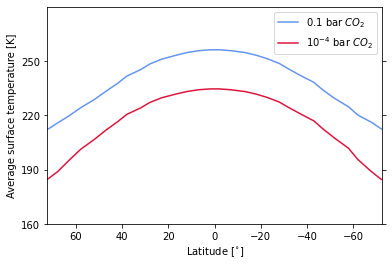

In [5]:
filenames = ['out/model0pt1barCO2.out','out/model0pt1mbarCO2.out']
labels = ["0.1 bar $CO_{2}$", "$10^{-4}$ bar $CO_{2}$"]
colors = ["cornflowerblue","crimson"]

plt.figure()
for i in range(len(filenames)):
    df = pd.read_csv(filenames[i], header=None)
    df = pd.DataFrame(df[0].str.split(' ').tolist())
        
    #Average temperature from text file
    temp_av = df.iloc[56:72,14]
    temp_av = temp_av.append(df.iloc[72:74,15])
    temp_av = temp_av.append(df.iloc[74:76,16])
    temp_av = temp_av.append(df.iloc[76:92,15])
    temp_av = np.array(temp_av, dtype = np.float32)
                
    temp_av_value = df.iloc[42,7]
    print (temp_av_value)

    latitude = df.iloc[56:72,4]
    latitude = latitude.append(df.iloc[72:74,5])
    latitude = latitude.append(df.iloc[74:76,6])
    latitude = latitude.append(df.iloc[76:92,5])
    latitude = np.array(latitude, dtype = np.float32)
    
    plt.plot(latitude,temp_av,color=colors[i],label=labels[i])
plt.legend()
plt.xlabel("Latitude [$^{\circ}$]")
plt.ylabel("Average surface temperature [K]")
plt.xlim([72.5, -72.5])
plt.ylim([160,280])
plt.yticks(np.arange(160, 280, 30))
ax = plt.gca()
ax.yaxis.set_ticks_position('both')
plt.savefig('Figures/Hoffman_comparison.pdf', bbox_inches='tight',format='pdf')
plt.show()

## CO2 phase curve

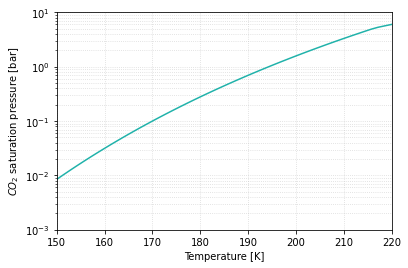

In [4]:
T = np.linspace(150,220,50)
PSL = np.zeros((len(T),1),dtype=np.float64)

for j in range(len(T)):
    if T[j]<216.56:
        PSL[j] = 6.760956 - 1284.07/(T[j] - 4.718) + 1.256e-4*(T[j] - 143.15)
    else:
        PSL[j] = 3.128082 - 867.2124/T[j] + 1.865612E-2*T[j] - 7.248820E-5*T[j]**2 + 9.3e-8*T[j]**3
        
        
PATM = 10.**PSL
PSCO2 = 1.013*PATM

plt.figure()
plt.semilogy(T,PSCO2,color='lightseagreen') 
plt.xlabel('Temperature [K]')
plt.ylabel('$CO_{2}$ saturation pressure [bar]')
plt.grid(which='both',linestyle=':',alpha=0.5)
plt.ylim([1e-3,10])
plt.xlim([150,220])
plt.savefig('Figures/CO2_phasecurve.pdf', bbox_inches='tight',format='pdf')
plt.show()